In [1]:
import pandas as pd
import numpy as np
sales = pd.read_excel('cryptopunk_sales.xlsx')
metadata = pd.read_csv('cryptopunk_metadata.csv')
# there are 1.4k blow $30
sales = sales[sales.amount_usd>30]
sales['block_date']= pd.to_datetime(sales.block_date)
sales = sales[sales.block_date> '2021-02-01']

sales = sales[['block_date', 'block_month', 'token_id', 'amount_usd', 'amount_original']]

unique_attributes = set()
attribute_columns = [col for col in metadata.columns if 'Attribute' in col]
for col in attribute_columns:
    unique_attributes.update(metadata[col].dropna().unique())

# Creating dummy variables
for attribute in unique_attributes:
    metadata[attribute] = metadata[attribute_columns].apply(lambda x: attribute in x.values, axis=1).astype(int)

# Displaying the result
metadata.head()

metadata = metadata[pd.Series(metadata.columns)[~pd.Series(metadata.columns).isin(attribute_columns)]]
sales = pd.merge(sales, metadata, left_on = 'token_id', right_on = 'ID')

import pandas as pd
import requests

def get_ethereum_price_history():
    # URL of the API endpoint (using CoinGecko as an example)
    url = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=max'

    # Make a request to the API
    response = requests.get(url)
    data = response.json()

    # Extract dates and prices
    prices = data['prices']  # This might vary based on the API structure
    dates = [pd.to_datetime(price[0], unit='ms') for price in prices]
    eth_prices = [price[1] for price in prices]

    # Create a DataFrame
    eth = pd.DataFrame({'Date': dates, 'Ethereum_Price': eth_prices})

    return eth

# Fetch and display the DataFrame
eth = get_ethereum_price_history()


sales = pd.merge(sales, eth, left_on  = 'block_date', right_on = 'Date')

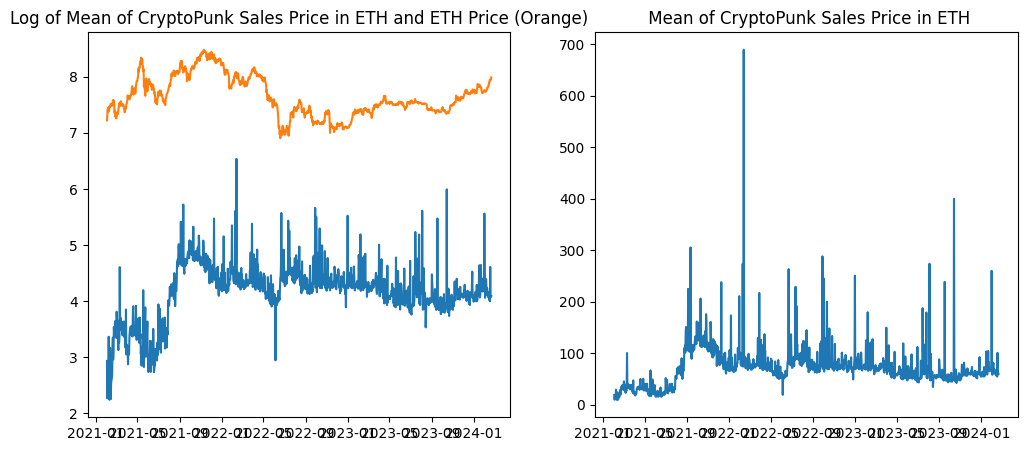

In [2]:
import matplotlib.pyplot as plt

sales['block_date'] = pd.to_datetime(sales.block_date)
sales_sorted = sales.sort_values(by='block_date')
mean_amount = sales_sorted.groupby('block_date').amount_original.mean()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot on the first subplot
axs[0].plot(np.log(mean_amount))
axs[0].plot(np.log(sales_sorted.groupby('block_date').Ethereum_Price.mean()))
axs[0].set_title('Log of Mean of CryptoPunk Sales Price in ETH and ETH Price (Orange)')

# Plot on the second subplot
axs[1].plot(mean_amount)
axs[1].set_title(' Mean of CryptoPunk Sales Price in ETH')

plt.show()


In [3]:
sales = sales[['amount_original',
       'Gender', 'Category', 'Front Beard Dark', 'VR', 'Clown Eyes Green',
       'Buck Teeth', 'Wild Hair', 'Silver Chain', 'Cigarette',
       'Purple Eye Shadow', 'Pigtails', 'Handlebars', 'Normal Beard',
       'Blonde Bob', 'Muttonchops', 'Smile', 'Shaved Head', 'Mustache',
       'Mohawk Dark', 'Straight Hair', 'Choker', 'Regular Shades',
       'Peak Spike', 'Tassle Hat', 'Dark Hair', 'Knitted Cap', 'Bandana',
       'Pink With Hat', 'Gold Chain', 'Mohawk', 'Welding Goggles',
       'Cap Forward', 'Tiara', 'Purple Lipstick', 'Small Shades',
       'Stringy Hair', 'Do-rag', 'Wild White Hair', 'Frown', 'Red Mohawk',
       'Half Shaved', 'Clown Hair Green', 'Vampire Hair', 'Beanie',
       'Clown Nose', 'Messy Hair', 'Blonde Short', 'Mole', 'Purple Hair',
       'Chinstrap', 'Orange Side', 'Hot Lipstick', 'Horned Rim Glasses', 'Cap',
       'Green Eye Shadow', 'Nerd Glasses', 'Rosy Cheeks', 'Pilot Helmet',
       'Straight Hair Dark', 'Medical Mask', 'Frumpy Hair', 'Wild Blonde',
       'Hoodie', 'Earring', 'Big Shades', 'Spots', 'Headband', 'Goat',
       'Big Beard', 'Classic Shades', 'Clown Eyes Blue', 'Blue Eye Shadow',
       'Cowboy Hat', 'Luxurious Beard', 'Crazy Hair', 'Normal Beard Black',
       'Fedora', 'Straight Hair Blonde', 'Vape', 'Mohawk Thin', 'Front Beard',
       '3D Glasses', 'Police Cap', 'Top Hat', 'Shadow Beard', 'Eye Mask',
       'Black Lipstick', 'Eye Patch', 'Pipe', 'block_month']]

to_dummies = ['Gender','block_month' ]#,  'skinColor']# 'year_month', 

for column in to_dummies:
    dummies = pd.get_dummies(sales[column])
    # Generate dummy variables
 
    # Prefix the original column name to each dummy column
    dummies.columns = [f"{column}_{col}" for col in dummies.columns]

    # Now, `dummies` has column names with both the original column name and the value.
    sales = pd.concat([sales, dummies], axis=1)

for column in to_dummies:
    sales.drop(column, axis=1, inplace=True)

sales = sales.dropna(subset = 'amount_original')

sales.reset_index(inplace=True, drop=True)

X = sales[pd.Series(sales.columns)[pd.Series(sales.columns)!='amount_original'].values]

y = sales['amount_original']  # Your target vector

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 13395, number of used features: 128
[LightGBM] [Info] Using GPU Device: GeForce GTX 960, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups (0.10 MB) transferred to GPU in 0.000986 secs. 1 sparse feature groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 63.105662
Mean absolute error in ETH 16.084230450316635
MAPE 29.857441987738884


c:\Users\erq\Desktop\Cryptopunks_Price_Prediction\plot_utils.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[0]


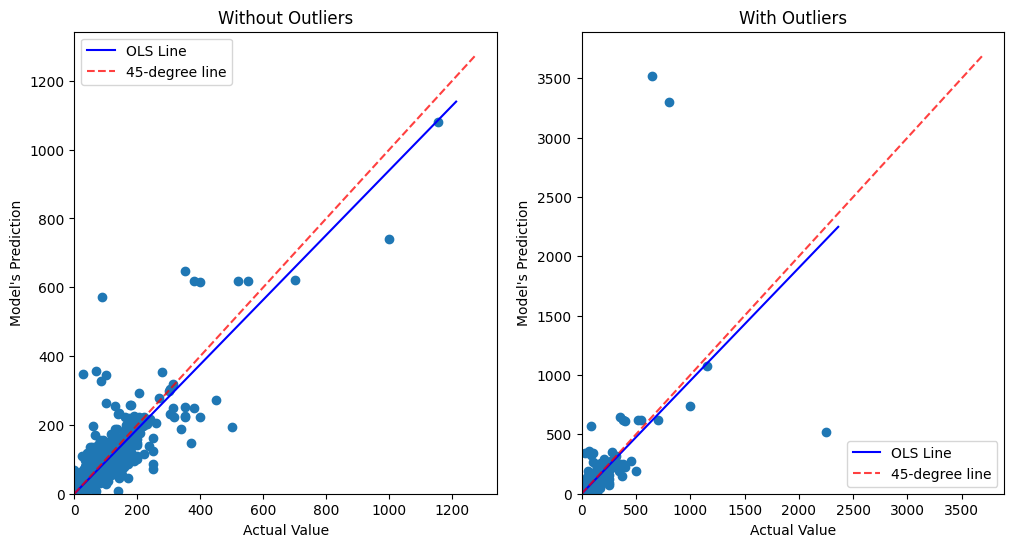

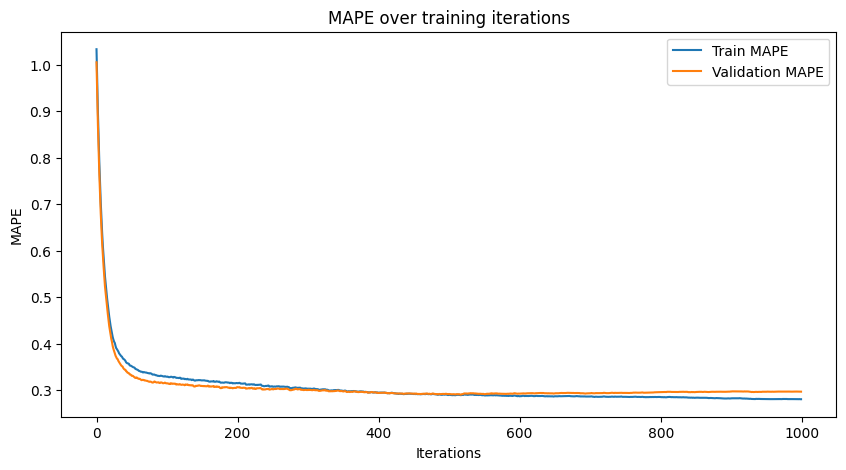

Axes(0.125,0.11;0.775x0.77)


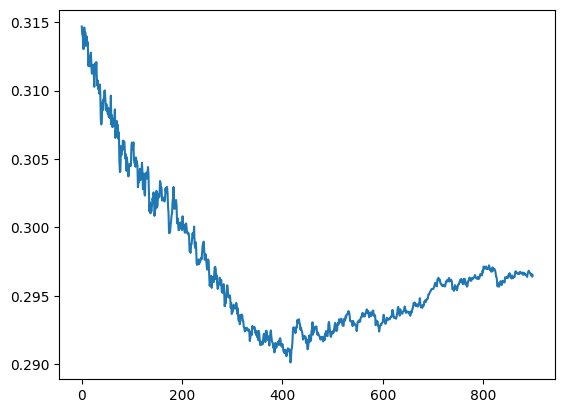

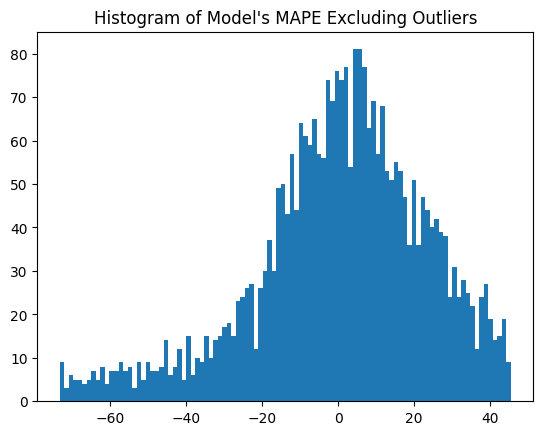

In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


dtrain = lgb.Dataset(X_train[pd.Series(X_train.columns)[~pd.Series(X_train.columns).isin(['numberId', 'year_month'])].values], label=y_train)
dval = lgb.Dataset(X_test[pd.Series(X_test.columns)[~pd.Series(X_test.columns).isin(['numberId', 'year_month'])].values], label=y_test, reference=dtrain)
# params = {
#     'objective': 'regression',
#     'metric': 'mape',
#     'device': 'gpu',
#     'max_depth': 8, 
#     'min_child_weight': 1, 
#     'gamma': 3.749732031778154, 
#     'subsample': 0.6404975719633969, 
#     'colsample_bytree': 0.87603386250907, 
#     'learning_rate': 0.08799757877730988, 
#     'num_leaves': 58, 
#     'reg_lambda': 2.4738609327026255, 
#     'reg_alpha': 3.2725786112011095}


params = {
    'objective': 'regression',
    'metric': 'mape',
    'device': 'gpu',
    }


evals={}

bst = lgb.train(params = params, train_set = dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'val'], num_boost_round=1000,
                callbacks=[
                        #lgb.early_stopping(stopping_rounds=300), 
                        lgb.record_evaluation(evals)] )

X_test['y_pred_gb_lgb'] = bst.predict(X_test[pd.Series(X_test.columns)[~pd.Series(X_test.columns).isin(['numberId', 'year_month'])].values], num_iteration=bst.best_iteration)
X_test['y_test'] = y_test
X_test['error'] = X_test['y_test'] - X_test['y_pred_gb_lgb']
X_test['perc_error']  = ((1- (X_test['y_test']/X_test['y_pred_gb_lgb']))*100)
X_test['perc_error_abs'] = X_test.perc_error.abs()

print('Mean absolute error in ETH', X_test['error'].abs().mean())
print('MAPE', X_test['perc_error_abs'].mean())

from plot_utils import *
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot without outliers
subset_no_outliers = X_test[(X_test['y_test'] < 2000) & (X_test['y_pred_gb_lgb'] < 2000)]
plot_scatter_predictions_and_actuals_with_OLS(axs[0], subset_no_outliers, 'Without Outliers')

# Plot with outliers
plot_scatter_predictions_and_actuals_with_OLS(axs[1], X_test, 'With Outliers')
# Usage with histogram

plt.figure(figsize=(10, 5))
plt.plot(evals['train']['mape'], label='Train MAPE')
plt.plot(evals['val']['mape'], label='Validation MAPE')
plt.xlabel('Iterations')
plt.ylabel('MAPE')
plt.title('MAPE over training iterations')
plt.legend()
plt.show()

print(pd.Series(evals['val']['mape'][100:]).plot())


import matplotlib.pyplot as plt
import numpy as np

# Assuming 'exclude_top_and_bottom_5_percent' and 'X_test' are already defined
series_perc_error = exclude_top_and_bottom_5_percent(X_test['perc_error'])

# Create a figure and axis
fig, ax = plt.subplots()

# Calculate histogram data
counts, bin_edges = np.histogram(series_perc_error, bins=100)

# Plot histogram
ax.hist(bin_edges[:-1], bin_edges, weights=counts)

# Set the title and other attributes
ax.set_title('Histogram of Model\'s MAPE Excluding Outliers')

# Display the plot
plt.show()


In [ ]:
# this find the best comvination of hyperparameters for light lgb using Optuna
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
import optuna
import numpy as np
def objective(trial):

    params = {
        'objective': 'regression',    
        'device': 'gpu',
        'metric': 'mape',
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'gamma': trial.suggest_float('gamma', 2.5, 5.0),
        'subsample': trial.suggest_float('subsample', 0.55, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 40, 120),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.5, 5, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 2, 5)
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    dtrain = lgb.Dataset(X_train[pd.Series(X_train.columns)[~pd.Series(X_train.columns).isin(['numberId', 'year_month'])].values], label=y_train)
    dval = lgb.Dataset(X_test[pd.Series(X_test.columns)[~pd.Series(X_test.columns).isin(['numberId', 'year_month'])].values], label=y_test, reference=dtrain)
    

    evals={}
    
    bst = lgb.train(params = params, train_set = dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'val'],
                    num_boost_round=2000,
                    callbacks=[
                        #lgb.early_stopping(stopping_rounds=300), 
                        lgb.record_evaluation(evals)] )
    
    # Since scores are negative, take the absolute to get positive RMSE values
    
    X_test['y_pred_gb_lgb'] = bst.predict(X_test[pd.Series(X_test.columns)[~pd.Series(X_test.columns).isin(['numberId', 'year_month'])].values], num_iteration=bst.best_iteration)
    X_test['y_test'] = y_test
    X_test['y_pred_gb_lgb'] = np.maximum(0, X_test['y_pred_gb_lgb'])
    X_test['error'] = X_test['y_test'] - X_test['y_pred_gb_lgb']
    X_test['perc_error']  = ((1- (X_test['y_test']/X_test['y_pred_gb_lgb']))*100)
    X_test['perc_error_abs'] = X_test.perc_error.abs()
    X_test[X_test['perc_error']>-299.99].perc_error.hist(bins=10)

    print(X_test[X_test['perc_error']>-299.99].perc_error.abs().mean())

    print(X_test['error'].abs().mean())
    

    plt.figure(figsize=(10, 5))
    plt.plot(evals['train']['mape'], label='Train MAPE')
    plt.plot(evals['val']['mape'], label='Validation MAPE')
    plt.xlabel('Iterations')
    plt.ylabel('MAPE')
    plt.title('MAPE over training iterations')
    plt.legend()
    plt.show()
    print(pd.Series(evals['val']['mape'][100:]).plot())
    return X_test[X_test['perc_error']>-299.99].perc_error.abs().mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_params = study.best_trial.params
print(f"Best params: {best_params}")

results_df_xgb = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

plt.figure(figsize=(10, 6))  # Width=10 inches, Height=6 inches
ax = results_df_xgb.value.plot.hist(density=True, alpha=0.5, bins=20)  # 'alpha' for translucency, 'bins' for granularity
results_df_xgb.value.plot.density(ax=ax)
ax.set_xlabel('MAPE')
ax.set_ylabel('Density')
plt.title('Optimization History of LGB Using Optuna')
print(plt.show())
results_df_xgb

In [ ]:
print(f"Best params: {best_params}")

In [82]:
X_test[['y_test', 'y_pred_gb_lgb']]

,y_test,y_pred_gb_lgb
8046,86.94,85.298203
1208,50.00,82.444379
3826,30.00,25.486303
99,100.00,87.322406
14776,94.95,85.268143
...,...,...
8067,8.23,11.023436
4032,65.90,63.157670
868,58.14,75.449428
10310,65.45,41.532284


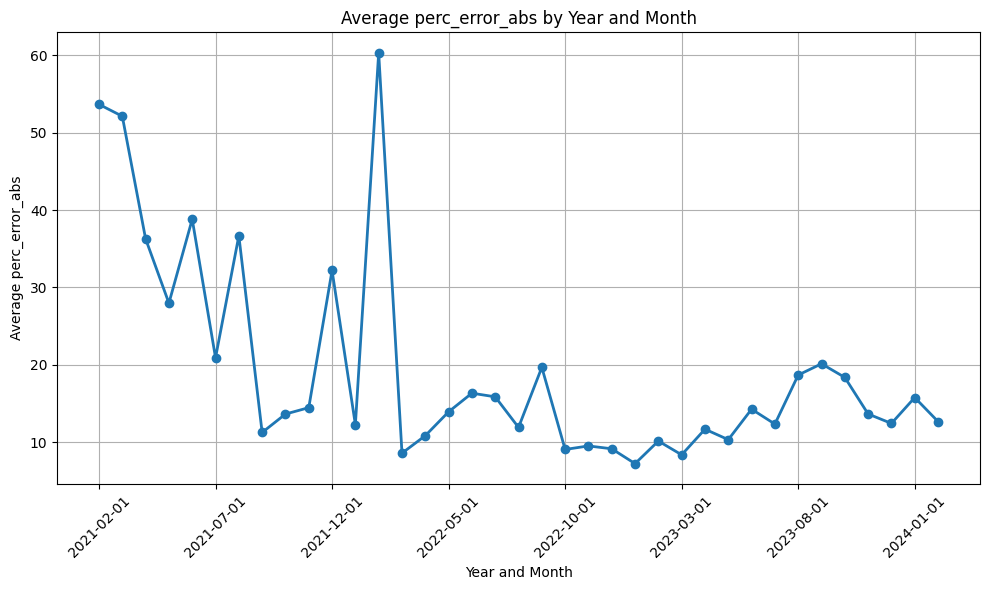

In [84]:

def dummies_to_block_month(df_dummies):
    block_month_series = df_dummies.idxmax(axis=1)
    block_month_series = block_month_series.str.replace('block_month_', '')
    return block_month_series

# Filter the DataFrame to include only the dummy columns for block_month
df_dummies = X_test.filter(like='block_month_')
X_test['block_month'] = dummies_to_block_month(df_dummies)
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
X_test.groupby('block_month').mean()['perc_error_abs'].plot(kind='line', marker='o', linestyle='-', linewidth=2, markersize=6)

plt.title('Average perc_error_abs by Year and Month')  # Title of the plot
plt.xlabel('Year and Month')  # X-axis label
plt.ylabel('Average perc_error_abs')  # Y-axis label
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()

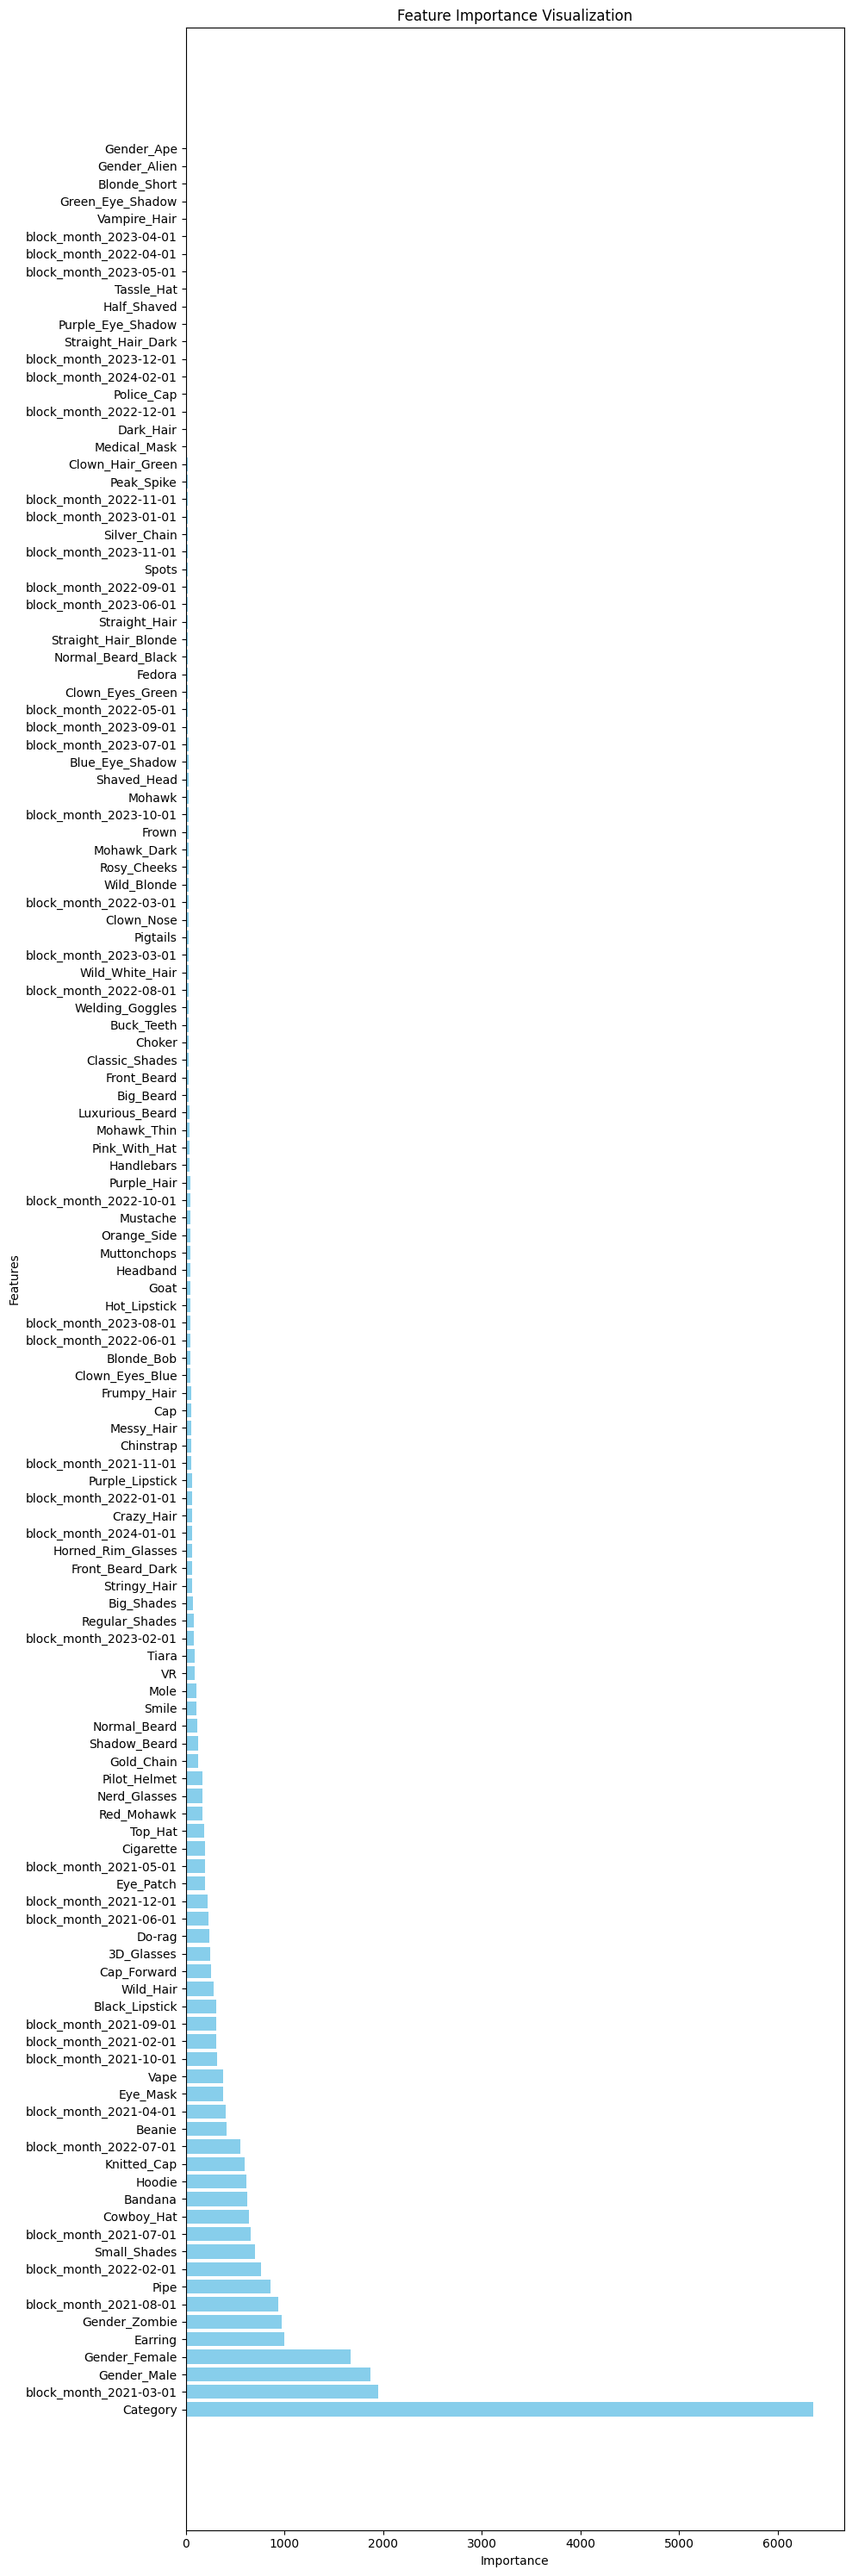

In [83]:
# Get feature importance
importance = bst.feature_importance()

# Get feature names
feature_names = bst.feature_name()

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Creating the plot
plt.figure(figsize=(10, 30))
plt.barh(feature_importance_df['Feature Name'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Visualization')
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
# Explainable AI
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


dtrain = lgb.Dataset(X_train[pd.Series(X_train.columns)[~pd.Series(X_train.columns).isin(['numberId', 'year_month'])].values], label=y_train)
dval = lgb.Dataset(X_test[pd.Series(X_test.columns)[~pd.Series(X_test.columns).isin(['numberId', 'year_month'])].values], label=y_test, reference=dtrain)

import shap
import seaborn as sns
bst = lgb.train(params = params, train_set = dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'val'], num_boost_round=10000,
                callbacks=[
                        #lgb.early_stopping(stopping_rounds=300), 
                        lgb.record_evaluation(evals)] )

chosen_model = bst  

# Explain the model with SHAP
explainer_cv = shap.TreeExplainer(chosen_model)
shap_values_cv = explainer_cv.shap_values(X_test)

try:
    shap_df_cv = pd.DataFrame(shap_values_cv[1], columns=X_test.columns)
except:
    #for xgboost
    shap_df_cv = pd.DataFrame(shap_values_cv, columns=X_test.columns)
import shap
import seaborn as sns
shap.initjs()



X_test_cv_v = X_test.copy()
X_test_cv_v.columns = X_test_cv_v.columns+"_value"
shap_df_cv_feature_values = pd.concat([shap_df_cv.reset_index(drop=True), X_test_cv_v.reset_index(drop=True)], axis=1)

# Append the SHAP values to the aggregate DataFrame
shap_aggregate = shap_df_cv
all_y_test_cv = y_test

shap_aggregate_feature_values = shap_df_cv_feature_values
mean_shap_values = shap_aggregate.mean()

all_y_test_cv.columns = ['y']

manual_effects = pd.DataFrame()

for i, column in enumerate(X_test.columns):
   print(column)

   effects_feature = pd.concat([shap_aggregate_feature_values[[f'{column}', f'{column}_value']].reset_index(drop=True), all_y_test_cv.reset_index(drop=True)], axis=1)
   m_effects = pd.DataFrame()
   m_effects.loc[0, 'feature'] = column
   m_effects.loc[0, 'sign'] = 'Feature is Positive'
   m_effects.loc[0, 'effect'] = effects_feature[effects_feature[f'{column}_value'] >=1][column].median()
   manual_effects =pd.concat([manual_effects, m_effects], axis=0)
   
   m_effects = pd.DataFrame()
   m_effects.loc[0, 'feature'] = column
   m_effects.loc[0, 'sign'] = 'Feature is Negative'
   m_effects.loc[0, 'effect'] =effects_feature[effects_feature[f'{column}_value'] ==0][column].median()
   manual_effects =pd.concat([manual_effects, m_effects], axis=0)


plt.figure(figsize=(14, 10))

sns.barplot(x='effect', y='feature', hue='sign', data=manual_effects, palette='coolwarm')
plt.tick_params(axis='y', labelsize=8)

plt.tick_params(labelsize=8)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 19501, number of used features: 171
[LightGBM] [Info] Using GPU Device: GeForce GTX 960, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups (0.15 MB) transferred to GPU in 0.000880 secs. 1 sparse feature groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 43.922266
